# Project Computer Vision
### By: Bulloni Dyuman, Margni Nathan
### Supervisor: Giusti Alessandro

In [1]:
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt 
import skimage

ModuleNotFoundError: No module named 'skimage'

# Data Loading

In [ ]:
train = pd.read_csv("data/labeled_pixels/train_sample.csv").drop(['Unnamed: 0'], axis=1)
test = pd.read_csv("data/labeled_pixels/test_sample.csv").drop(['Unnamed: 0'], axis=1)

In [ ]:
train_idxs = np.random.permutation(len(train))
test_idxs = np.random.permutation(len(test))

shuffled_train = np.array(train, dtype=float)[train_idxs]
shuffled_test = np.array(test, dtype=int)[test_idxs]

In [ ]:
def show_dataset_sample(images, masks, limit=10):
    assert images.shape[0] >= limit and masks.shape[0] >= limit
    im_l = images[:limit]
    msk_l = masks[:limit]
    fig, ax = plt.subplots(im_l.shape[0], 2, figsize=(10,50))
    for idx in range(im_l.shape[0]):
        ax[idx, 0].imshow(im_l[idx])
        ax[idx, 1].imshow(msk_l[idx], vmin=0, vmax=1)
    plt.show()

def show_predictions(model, images, true_masks, n_to_show = 10, flat_data = False, title = "Mask predictions"):
    fig, ax = plt.subplots(n_to_show, 3, figsize=(10, 30))
    for row in range(n_to_show):
        if flat_data:
            predicted_mask = model.predict(images[row].reshape(512*512, 3)).reshape(512, 512)
        else:
            predicted_mask = model.predict(np.array([images[row]]), verbose=False)[0]

        ax[row, 0].imshow(images[row])
        ax[row, 1].imshow(true_masks[row])
        ax[row, 2].imshow(predicted_mask)

    cols = ["Image", "ground truth", "predicted mask"]
    for axis, col in zip(ax[0], cols):
        axis.set_title(col, fontsize=10)

    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

In [ ]:
y_train_reg = shuffled_train[:, 3]
X_train_reg = shuffled_train[:, :3]

y_test_reg = shuffled_test[:, 3]
X_test_reg = shuffled_test[:, :3]


In [7]:
def colorize(num):
    if num == 1:
        return [0, 0, 0.8]
    else:
        return [0, 0, 0]

def colorize_array(arr):
    new_arr = []
    for num in  arr:
        new_arr.append(colorize(num))
    new_arr = np.array(new_arr)
    return new_arr.reshape(512, 512, 3)

def get_images(file):
    return skimage.io.imread(("data/output/" + file + ".jpg"))

def get_masks(file):
    return binary_mask(skimage.io.imread(("data/output/" + file + "_m.png"))[:, :, 0])


def binary_mask(mask):
    return np.where(mask == 2, 1, 0)

In [8]:
with open('data/train.txt', 'r') as f:
    train_files_original = []
    line = f.readline()
    while line:
        line = line.strip()
        train_files_original.append(line)
        line = f.readline()

with open('data/test.txt', 'r') as f:
    test_files_original = []
    line = f.readline()
    while line:
        line = line.strip()
        test_files_original.append(line)
        line = f.readline()

with open('data/val.txt', 'r') as f:
    val_files_original = []
    line = f.readline()
    while line:
        line = line.strip()
        val_files_original.append(line)
        line = f.readline()

In [28]:
import random
np.random.seed(42)
train_files = random.sample(train_files_original, 500)
test_files = random.sample(test_files_original, 100)
val_files = random.sample(val_files_original, 100)

X_train  = np.array(list(map(get_images, train_files)))
y_train  = np.array(list(map(get_masks, train_files)))

X_test = np.array(list(map(get_images, test_files)))
y_test  = np.array(list(map(get_masks, test_files)))

X_val = np.array(list(map(get_images, val_files)))
y_val  = np.array(list(map(get_masks, val_files)))

## A first look at the data

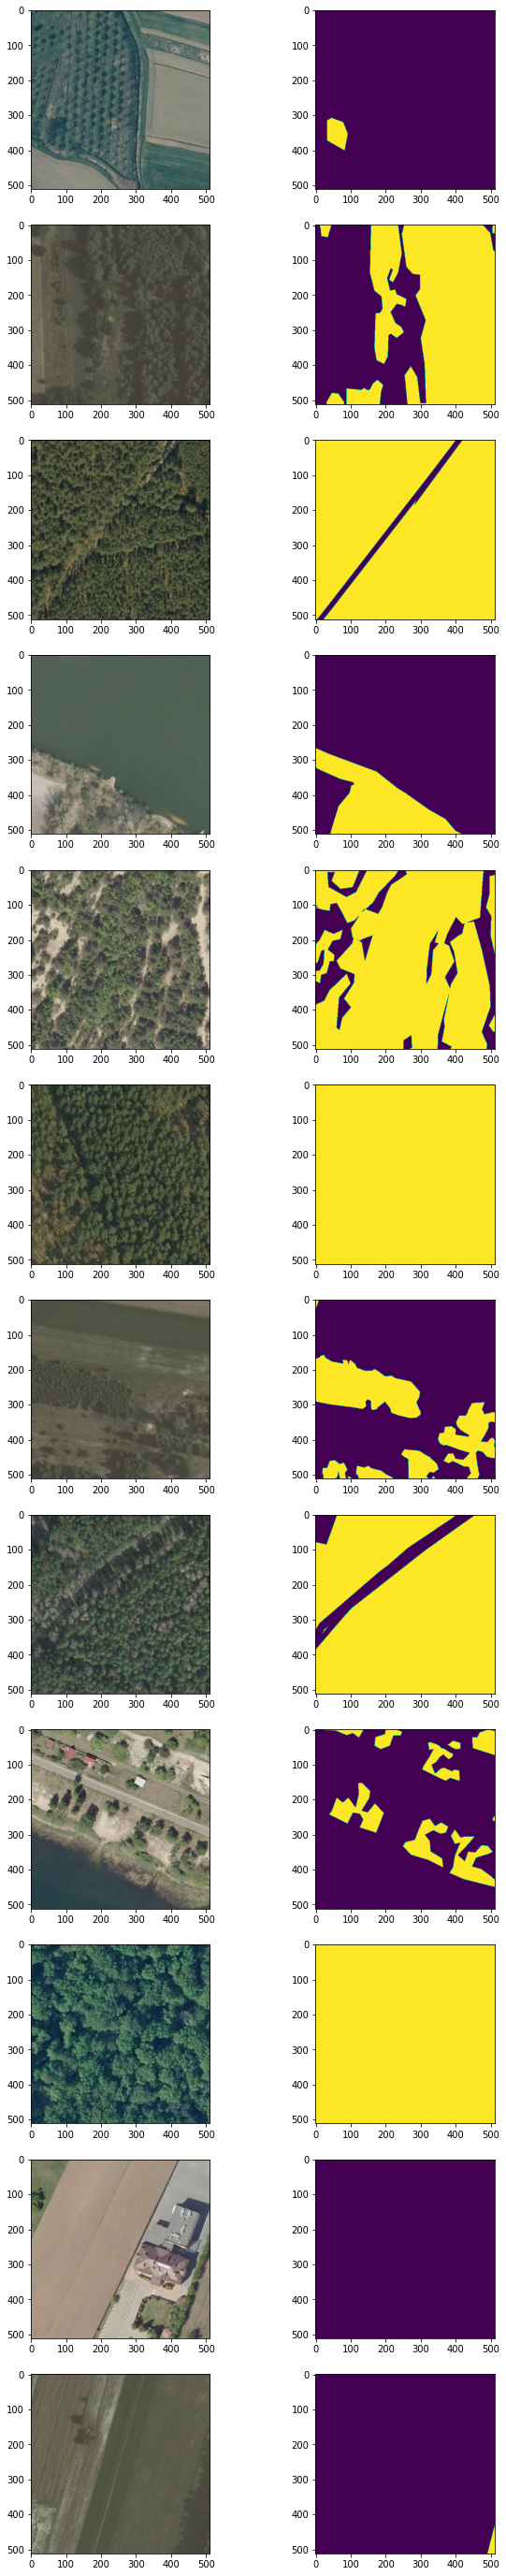

In [213]:
show_dataset_sample(X_train, y_train, 10)

Except the first image that seems strange as there should be much more trees, the other data seem reasonable enough to perform a meaningful evaluation of the class woodland. 

# Logistic Regression over RGB values

In [32]:
logreg = LogisticRegression()
logreg.fit(X_train_reg, y_train_reg)
pred = logreg.predict(X_test_reg)

In [6]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print("mean accuracy on test set: ", np.mean(y_pred==y_test))
    print("fscore on test set: ", f1_score(y_test, y_pred, zero_division=True))
    print("auc score test set: ", roc_auc_score(y_test, y_pred))

    print("confusion matrix:")
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    cm_display.plot()
    plt.show()

              precision    recall  f1-score   support

           0       0.70      0.64      0.67      2969
           1       0.67      0.73      0.70      2973

    accuracy                           0.68      5942
   macro avg       0.69      0.68      0.68      5942
weighted avg       0.69      0.68      0.68      5942

mean accuracy on test set:  0.6841130932346011
fscore on test set:  0.6987642432996309
auc score test set:  0.6840806621896384
confusion matrix:


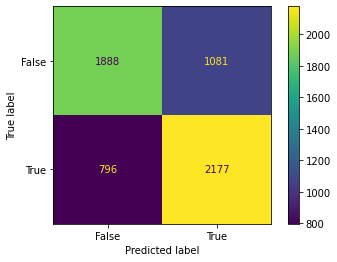

In [215]:
evaluate_model(logreg, X_test_reg, y_test_reg)

The value is decent, with an auc score of 0.684 it means that it performs quite well
even considering all the green that represent grass and not woodland.

Let's now see how the logistic classifier performs over the images.

In [216]:
X_test.shape

(100, 512, 512, 3)

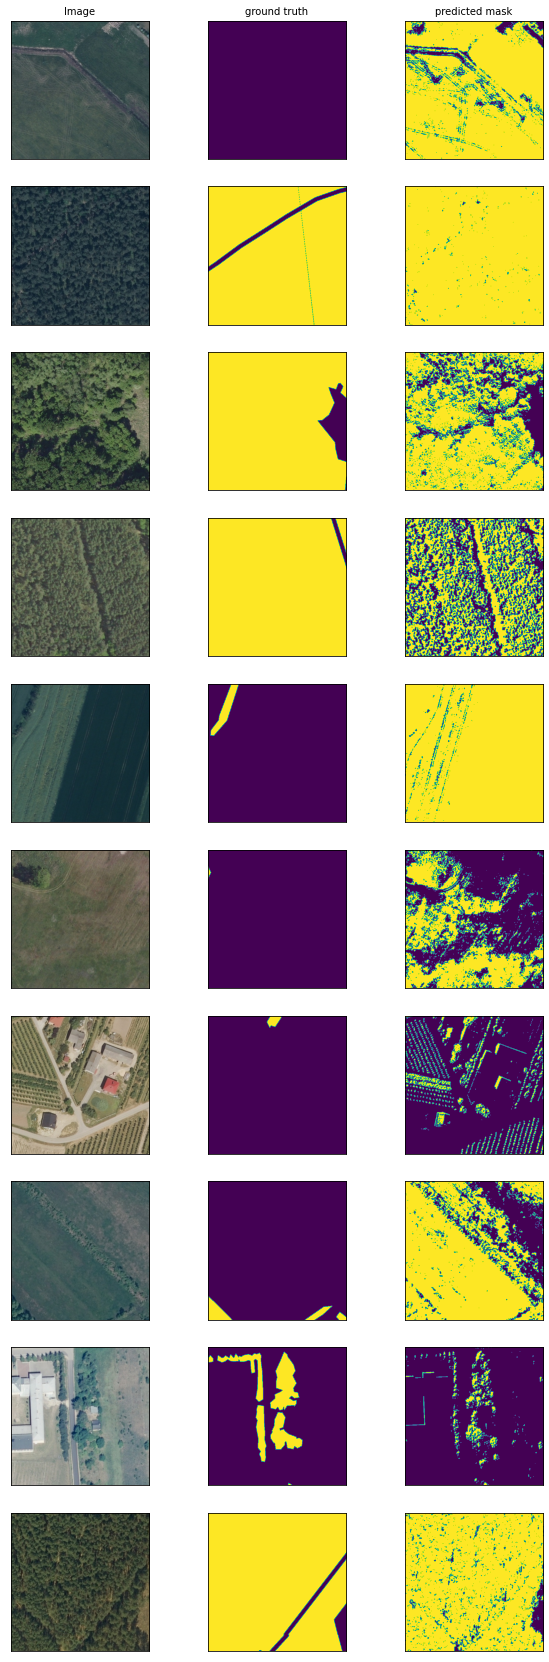

In [234]:
show_predictions(logreg, X_test, y_test, n_to_show=10,flat_data=True)

Since it looks only at the rgb values, it is sufficient to be green to be considered woodland, which includes clearly other elements such as grass. 

## Large Image with Logistic Classifier

In [10]:
# We guarantee that this image is only used for testing and not patch it is used for training and validation purposes. 
large_img_name = 'N-34-140-A-d-3-4'
large_img = skimage.io.imread(f'data/images/{large_img_name}.tif')
large_mask = np.where(skimage.io.imread(f'data/masks/{large_img_name}.tif') == 2, 1, 0)


In [260]:
large_img.shape

(9579, 8885, 3)

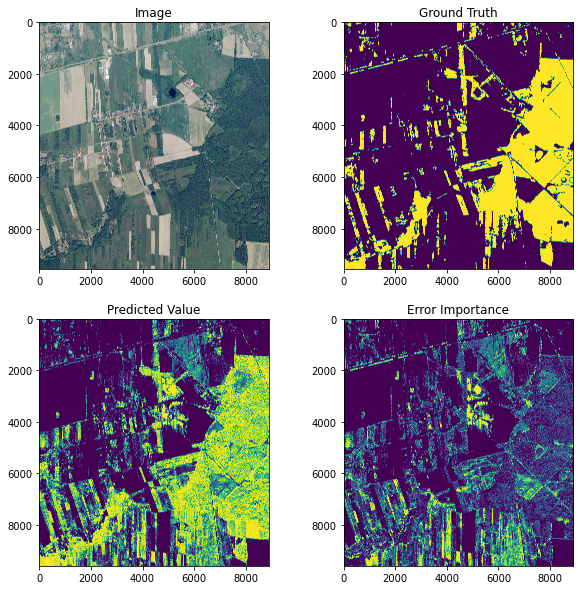

In [261]:
large_img_predicted = logreg.predict(np.array(large_img.reshape(large_img.shape[0]*large_img.shape[1],3))).reshape(large_mask.shape)

fig, ax = plt.subplots(2, 2, figsize=(10,10))
ax[0,0].imshow(large_img)
ax[0,0].set_title('Image')
ax[0,1].imshow(large_mask, vmin=0, vmax=1)
ax[0,1].set_title('Ground Truth')
ax[1,0].imshow(large_img_predicted)
ax[1,0].set_title('Predicted Value')
ax[1,1].imshow(np.abs(large_img_predicted-large_mask))
ax[1,1].set_title('Error Importance')


plt.show()

The same evaluation applies to the singular images, as green is predominant and the error parts are a discrete amount. 

# Modeling with NN

In [62]:
# Only for gpu purposes
"""
import tensorflow as tf
from tensorflow.python.client import device_lib 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))
assert tf.test.is_built_with_cuda()
"""

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:
from keras_tensorboard_pr_curves import PRCurve, ROCCurve, TensorBoardPRCurves
import keras
import keras.layers
import datetime
import tensorflow as tf

log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# source: https://github.com/keras-team/keras/issues/16104
metric_calls = [
        keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.AUC(name='AUC', curve='ROC'),
        tf.keras.metrics.AUC(name='AUPR', curve='PR'),
        PRCurve(name='pr_curve'),
        ROCCurve(name='roc_curve'),
    ]
callbacks = [TensorBoardPRCurves(log_dir='/logs', pr_curve_names=['pr_curve', 'roc_curve'], auc_names=['AUPR', 'AUC'])]


## A RGB Classifier with CNN

In [24]:
# Simple model that only considers the gray value of a single pixel to classify it
def mkmodel_rgb_cnn():
    input_layer = keras.Input(shape=(None, None, 3), name='input')
    x = keras.layers.Conv2D(filters=5, kernel_size=(1,1), padding='same', activation='relu')(input_layer)
    x = keras.layers.Conv2D(filters=1, kernel_size=(1,1), padding='same', activation='sigmoid')(x)
    return keras.Model(input_layer, x) 
model0 = mkmodel_rgb_cnn() 
model0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=keras.losses.BinaryCrossentropy(from_logits=False), 
              metrics=keras.metrics.BinaryAccuracy())


history0 = model0.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)

Epoch 1/100
16/16 [==============================] - 10s 566ms/step - loss: 4.6489 - binary_accuracy: 0.6517 - val_loss: 3.7116 - val_binary_accuracy: 0.3523
Epoch 2/100
16/16 [==============================] - 9s 567ms/step - loss: 2.0021 - binary_accuracy: 0.5970 - val_loss: 1.6575 - val_binary_accuracy: 0.6498
Epoch 3/100
16/16 [==============================] - 9s 575ms/step - loss: 1.6557 - binary_accuracy: 0.6106 - val_loss: 2.0197 - val_binary_accuracy: 0.4650
Epoch 4/100
16/16 [==============================] - 9s 556ms/step - loss: 1.5708 - binary_accuracy: 0.6143 - val_loss: 1.3474 - val_binary_accuracy: 0.5938
Epoch 5/100
16/16 [==============================] - 9s 560ms/step - loss: 1.2492 - binary_accuracy: 0.6233 - val_loss: 1.0777 - val_binary_accuracy: 0.6307
Epoch 6/100
16/16 [==============================] - 9s 584ms/step - loss: 1.1404 - binary_accuracy: 0.6022 - val_loss: 1.0600 - val_binary_accuracy: 0.7050
Epoch 7/100
16/16 [==============================] - 9s 5

4/4 [==============================] - 0s 60ms/step
              precision    recall  f1-score   support

           0       0.78      0.91      0.84  18248214
           1       0.65      0.40      0.50   7966186

    accuracy                           0.75  26214400
   macro avg       0.72      0.65      0.67  26214400
weighted avg       0.74      0.75      0.73  26214400

mean accuracy on test set:  0.7537080764770507
fscore on test set:  0.49795122042255524
roc_auc_score: 0.6546027360640956
confusion matrix:


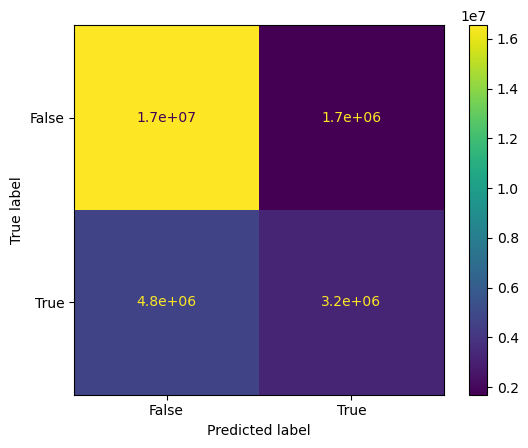

In [25]:
model0.save('models/rgb_nn.h5')
evaluate_mask_model(model0, X_test, y_test)

With an auc score of 0.65, it is slightly worse than the logistic regression, even using the same logic. 


## A simple 2D-Convolutional Approach

In [26]:
# Simple model that only considers the rgb value of a single pixel to classify it
def mkmodel_conv2():
    input_layer = keras.Input(shape=(None, None, 3), name='input')
    x = keras.layers.Conv2D(filters=4, kernel_size=(1,1), padding='same', activation='relu')(input_layer)
    x = keras.layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = keras.layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = keras.layers.Conv2D(filters=4, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = keras.layers.Conv2D(filters=1, kernel_size=(1,1), padding='same', activation='sigmoid')(x)
    return keras.Model(input_layer, x)

In [27]:
model_conv = mkmodel_conv2()
model_conv.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=keras.losses.BinaryCrossentropy(from_logits=False), 
              metrics=metric_calls)
print(model_conv.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, None, 3)]   0         
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 4)     16        
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 8)     296       
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 8)     584       
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 4)     292       
                                                                 
 conv2d_6 (Conv2D)           (None, None, None, 1)     5         
                                                                 
Total params: 1,193
Trainable params: 1,193
Non-trainable p

In [168]:
name = 'D_2_conv2'
model_conv.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=128, epochs=100)
model_conv.save(f'models/{name}.h5')

Epoch 1/100
4/4 [==============================] - 19s 2s/step - loss: 0.6711 - binary_accuracy: 0.5188 - AUC: 0.4408 - AUPR: 0.2478 - pr_curve: 4369066.0000 - roc_curve: 4369066.0000 - val_loss: 0.6650 - val_binary_accuracy: 0.6413 - val_AUC: 0.5020 - val_AUPR: 0.4098 - val_pr_curve: 655360.1250 - val_roc_curve: 655360.125
Epoch 2/100
4/4 [==============================] - 3s 601ms/step - loss: 0.6218 - binary_accuracy: 0.7053 - AUC: 0.5535 - AUPR: 0.3308 - pr_curve: 4369066.5000 - roc_curve: 4369066.5000 - val_loss: 0.6348 - val_binary_accuracy: 0.6413 - val_AUC: 0.5981 - val_AUPR: 0.4966 - val_pr_curve: 655360.1250 - val_roc_curve: 655360.125
Epoch 3/100
4/4 [==============================] - 3s 595ms/step - loss: 0.5985 - binary_accuracy: 0.7053 - AUC: 0.5839 - AUPR: 0.4234 - pr_curve: 4369066.5000 - roc_curve: 4369066.5000 - val_loss: 0.6330 - val_binary_accuracy: 0.6413 - val_AUC: 0.5950 - val_AUPR: 0.4897 - val_pr_curve: 655360.1250 - val_roc_curve: 655360.125
Epoch 4/100
4/4 [=

In [20]:
import sklearn
from sklearn.metrics import roc_auc_score
mask_threshold = 0.5
def evaluate_mask_model(model, X_test, y_test):
    mask = model.predict(X_test, callbacks=tensorboard_callback)
   
    y_pred = np.where(mask.flatten() > mask_threshold, 1, 0)
    y_test = y_test.flatten()
    print(classification_report(y_test, y_pred))
    print("mean accuracy on test set: ", np.mean(y_pred==y_test))
    print("fscore on test set: ", f1_score(y_test, y_pred, zero_division=True))
    print("roc_auc_score:", roc_auc_score(y_test, y_pred))
    print("confusion matrix:")
    confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
    cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    cm_display.plot()
    plt.show()
    
def plot_history(history):
    acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot the accuracy and loss curves
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, color="blue", label='Training acc')
    plt.plot(epochs, val_acc,   color="darkviolet", label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylim(0, 1)
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, color="blue",  label='Training loss')
    plt.plot(epochs, val_loss,  color="darkviolet",label='Validation loss')
    plt.title('Training and validation loss')

    plt.legend()
    plt.show()

2/2 [==============================] - 2s 608ms/st
              precision    recall  f1-score   support

           0       0.72      0.88      0.79   2426430
           1       0.70      0.44      0.54   1505730

    accuracy                           0.71   3932160
   macro avg       0.71      0.66      0.66   3932160
weighted avg       0.71      0.71      0.69   3932160

mean accuracy on test set:  0.7114412943522136
fscore on test set:  0.5375343539981063
roc_auc_score: 0.659551836896611
confusion matrix:


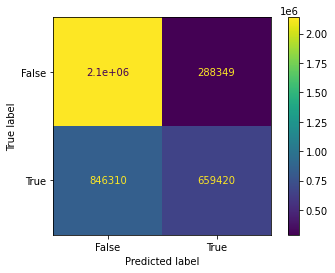

In [170]:
evaluate_mask_model(model_conv, X_test, y_test)

The model performed decently, with an roc auc of 0.660, but it is still less than the logistic regression, and therefore not really observe it. 

# Unet-like fully convolutional network approach

As the data is heavily impacting on our dataset, unfortunately we have to sample the data
keeping only a sample and patching it on a 256x256 shape, fixed on the center for each image.

In [29]:
import random
np.random.seed(42)
train_files = random.sample(train_files_original, 400)
test_files = random.sample(test_files_original, 60)
val_files = random.sample(val_files_original, 60)
center = 512 // 2
patch_size = 256 # default 512
patch_pos = (center-patch_size//2,center+patch_size//2)
X_train  = np.array(list(map(get_images, train_files)))[:,patch_pos[0]:patch_pos[1],patch_pos[0]:patch_pos[1],:]
y_train  = np.array(list(map(get_masks, train_files)))[:,patch_pos[0]:patch_pos[1],patch_pos[0]:patch_pos[1]]

X_test = np.array(list(map(get_images, test_files)))[:,patch_pos[0]:patch_pos[1],patch_pos[0]:patch_pos[1],:]
y_test  = np.array(list(map(get_masks, test_files)))[:,patch_pos[0]:patch_pos[1],patch_pos[0]:patch_pos[1]]

X_val = np.array(list(map(get_images, val_files)))[:,patch_pos[0]:patch_pos[1],patch_pos[0]:patch_pos[1],:]
y_val  = np.array(list(map(get_masks, val_files)))[:,patch_pos[0]:patch_pos[1],patch_pos[0]:patch_pos[1]]
X_train.shape

(400, 256, 256, 3)

In [176]:
import keras
import keras.layers

def mkmodel_unet():
    input_layer = keras.Input(shape=(None, None, 3), name='input')
    x = keras.layers.Conv2D(filters=4, kernel_size=(3,3), padding='same', activation='relu')(input_layer)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.SeparableConv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x1 = x
    x = keras.layers.MaxPooling2D(2)(x)
    x = keras.layers.SeparableConv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x2 = x
    x = keras.layers.MaxPooling2D(2)(x)
    x = keras.layers.SeparableConv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.SeparableConv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.Concatenate()([x,x2]) # Skip connections
    x = keras.layers.SeparableConv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.Concatenate()([x,x1]) # Skip connections
    x = keras.layers.SeparableConv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same', activation='relu')(x)
    x = keras.layers.Conv2D(filters=1, kernel_size=(1,1), padding='same', activation='sigmoid')(x)
    return keras.Model(input_layer, x)
model = mkmodel_unet()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=keras.losses.BinaryCrossentropy(from_logits=False), 
              metrics=metric_calls)
print(model.summary())

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_50 (Conv2D)             (None, None, None,   112         ['input[0][0]']                  
                                4)                                                                
                                                                                                  
 batch_normalization_84 (BatchN  (None, None, None,   16         ['conv2d_50[0][0]']              
 ormalization)                  4)                                                         

In [270]:
name = 'D_5_unet'

history_unet = model.fit(X_train, y_train, validation_data=(X_val, y_val),
          batch_size=32, epochs=100,  callbacks=[callbacks])
model.save(f'models/{name}.h5')

Epoch 1/100
13/13 [==============================] - 11s 877ms/step - loss: 0.3013 - binary_accuracy: 0.8701 - AUC: 0.9384 - AUPR: 0.8842 - pr_curve: 4369067.0000 - roc_curve: 4369066.5000 - val_loss: 0.2508 - val_binary_accuracy: 0.8956 - val_AUC: 0.9507 - val_AUPR: 0.8476 - val_pr_curve: 655360.1875 - val_roc_curve: 655360.125
Epoch 2/100
13/13 [==============================] - 11s 822ms/step - loss: 0.2986 - binary_accuracy: 0.8699 - AUC: 0.9396 - AUPR: 0.8833 - pr_curve: 4369067.0000 - roc_curve: 4369066.5000 - val_loss: 0.3305 - val_binary_accuracy: 0.8568 - val_AUC: 0.9210 - val_AUPR: 0.7849 - val_pr_curve: 655360.1875 - val_roc_curve: 655360.125
Epoch 3/100
13/13 [==============================] - 11s 821ms/step - loss: 0.3082 - binary_accuracy: 0.8654 - AUC: 0.9351 - AUPR: 0.8727 - pr_curve: 4369067.0000 - roc_curve: 4369066.5000 - val_loss: 0.2496 - val_binary_accuracy: 0.8930 - val_AUC: 0.9554 - val_AUPR: 0.8532 - val_pr_curve: 655360.1875 - val_roc_curve: 655360.125
Epoch 4

2/2 [==============================] - 1s 434ms/step
              precision    recall  f1-score   support

           0       0.98      0.90      0.94   3067690
           1       0.72      0.92      0.81    864470

    accuracy                           0.90   3932160
   macro avg       0.85      0.91      0.87   3932160
weighted avg       0.92      0.90      0.91   3932160

mean accuracy on test set:  0.9027135213216145
fscore on test set:  0.8060925737063749
roc_auc_score: 0.9088499104641089
confusion matrix:


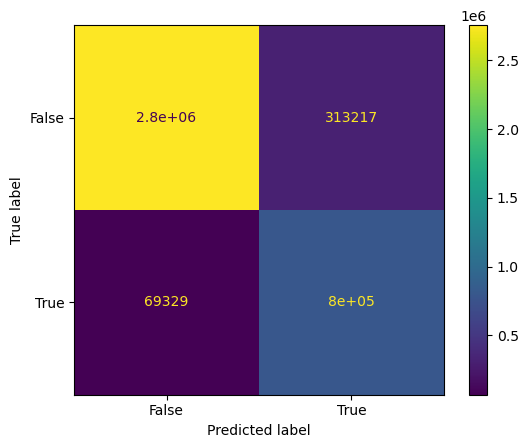

In [30]:
name = 'D_5_unet'
model = keras.models.load_model(f'models/{name}.h5', compile=False)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=metric_calls)
evaluate_mask_model(model, X_test, y_test)

A roc auc of 0.9.

In [189]:
def mkmodel_small():
    input_layer = keras.Input(shape=(None, None, 3), name='input')
    x = keras.layers.Conv2D(filters=4, kernel_size=(3,3), padding='same', activation='relu')(input_layer)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.SeparableConv2D(filters=6, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x1 = x
    x = keras.layers.MaxPooling2D(2)(x)
    x = keras.layers.SeparableConv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x2 = x
    x = keras.layers.MaxPooling2D(2)(x)
    x = keras.layers.SeparableConv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.SeparableConv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.Concatenate()([x,x2]) # Skip connections
    x = keras.layers.SeparableConv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.Concatenate()([x,x1]) # Skip connections
    x = keras.layers.SeparableConv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same', activation='relu')(x)
    x = keras.layers.Conv2D(filters=1, kernel_size=(1,1), padding='same', activation='sigmoid')(x)
    return keras.Model(input_layer, x)


model_sm = mkmodel_small()
model_sm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=metric_calls)
print(model_sm.summary())

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_53 (Conv2D)             (None, None, None,   112         ['input[0][0]']                  
                                4)                                                                
                                                                                                  
 batch_normalization_91 (BatchN  (None, None, None,   16         ['conv2d_53[0][0]']              
 ormalization)                  4)                                                         

In [264]:
name = 'D_5_unet_min'

history_sm = model_sm.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=100,  callbacks=[callbacks])

Epoch 1/100
13/13 [==============================] - 12s 890ms/step - loss: 0.4208 - binary_accuracy: 0.8116 - AUC: 0.8752 - AUPR: 0.7561 - pr_curve: 4369067.0000 - roc_curve: 4369067.0000 - val_loss: 0.6663 - val_binary_accuracy: 0.6596 - val_AUC: 0.7569 - val_AUPR: 0.5884 - val_pr_curve: 655360.1875 - val_roc_curve: 655360.125
Epoch 2/100
13/13 [==============================] - 12s 933ms/step - loss: 0.4056 - binary_accuracy: 0.8163 - AUC: 0.8837 - AUPR: 0.7837 - pr_curve: 4369067.0000 - roc_curve: 4369066.5000 - val_loss: 0.7210 - val_binary_accuracy: 0.6647 - val_AUC: 0.7603 - val_AUPR: 0.5923 - val_pr_curve: 655360.1250 - val_roc_curve: 655360.062
Epoch 3/100
13/13 [==============================] - 11s 882ms/step - loss: 0.3959 - binary_accuracy: 0.8193 - AUC: 0.8900 - AUPR: 0.7806 - pr_curve: 4369066.5000 - roc_curve: 4369066.0000 - val_loss: 0.7768 - val_binary_accuracy: 0.6700 - val_AUC: 0.7622 - val_AUPR: 0.6072 - val_pr_curve: 655360.1250 - val_roc_curve: 655360.062
Epoch 4

In [265]:
name = 'D_5_unet_min'
model_sm.save(f'models/{name}.h5')

# D_1_unet: 128x128,100+20+20 32 batch, 50 epochs
# D_2_unet: 256x256, 100+20+20, 32 batch, 50 epochs
# D_3_unet: 256x256, 500+100+100, 32 batch, 100 epochs (do not work anymore)
# D_4_unet: 256x256, 500+100+100, 32 batch, 100 epochs

2/2 [==============================] - 1s 318ms/st
              precision    recall  f1-score   support

           0       0.85      0.91      0.88   2514334
           1       0.82      0.71      0.76   1417826

    accuracy                           0.84   3932160
   macro avg       0.83      0.81      0.82   3932160
weighted avg       0.84      0.84      0.84   3932160

mean accuracy on test set:  0.8387056986490885
fscore on test set:  0.7601953872487097
roc_auc_score: 0.8104298613634667
confusion matrix:


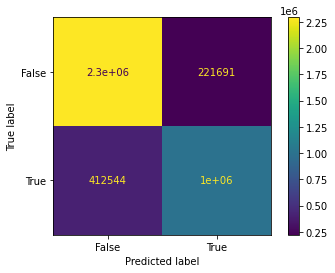

In [266]:
model = keras.models.load_model(f'models/{name}.h5', compile=False)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=metric_calls)
evaluate_mask_model(model, X_test, y_test)

This model was much faster than the other UNet-like FCN and also performed really similar, with a roc auc of 0.810. 
We can analyize its effects on the dataset and see where our image segmentation led as final result. 

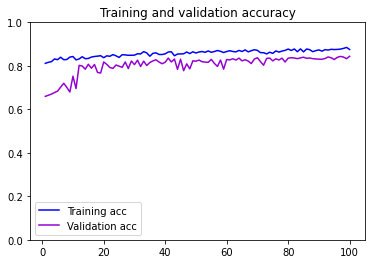

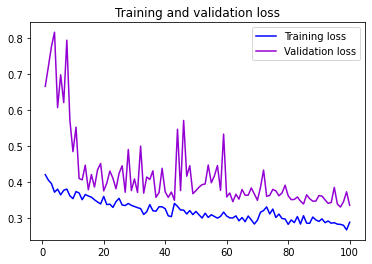

In [268]:
plot_history(history_sm)

In [11]:
large_img.shape
dim = min(large_img.shape[0], large_img.shape[1])-1

large_img = large_img[:dim,:dim]
print(large_img.shape)

(8884, 8884, 3)


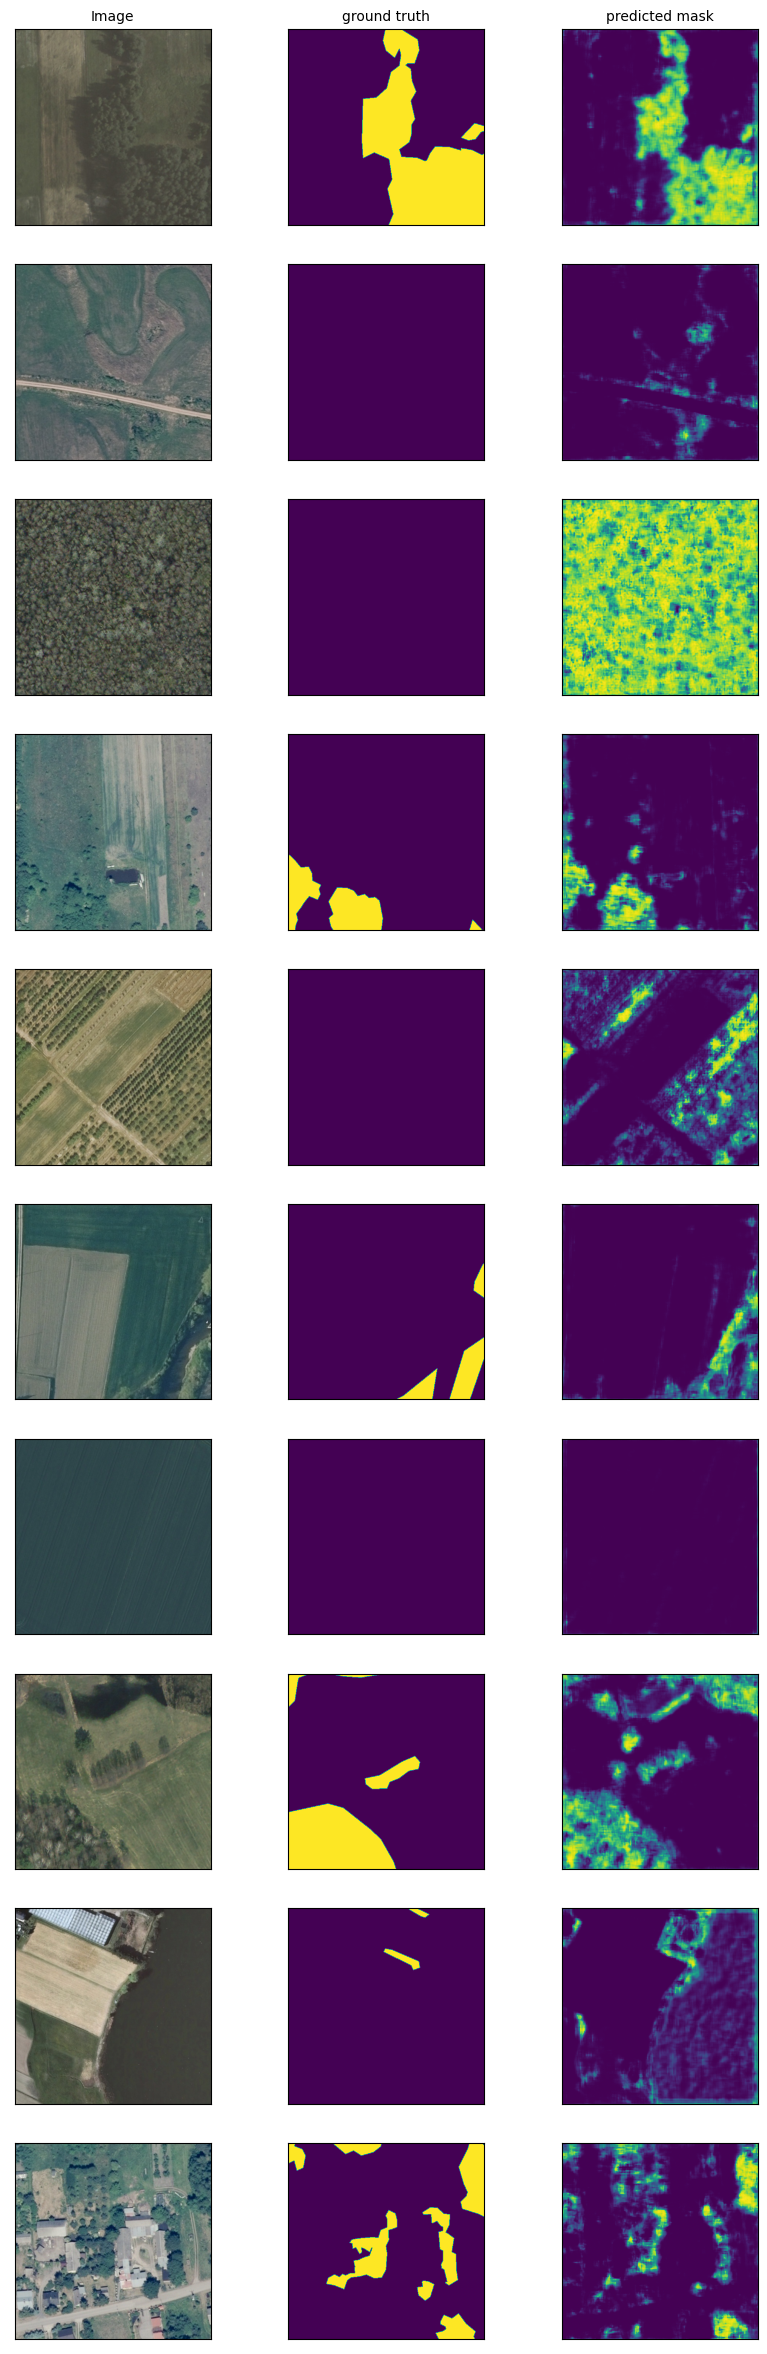

In [22]:
name= 'D_5_unet_min'
model = keras.models.load_model(f'models/{name}.h5', compile=False)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=metric_calls)
show_predictions(model, X_test, y_test, 10)

Interestingly, the small FCN seems to recognize singular trees better even where those were not part of the mask. 
It would have an interesting part to verify with other sources. 

1/1 [==============================] - 118s 118s/step


MemoryError: Unable to allocate 5.10 TiB for an array with shape (8884, 8884, 8884) and data type float64

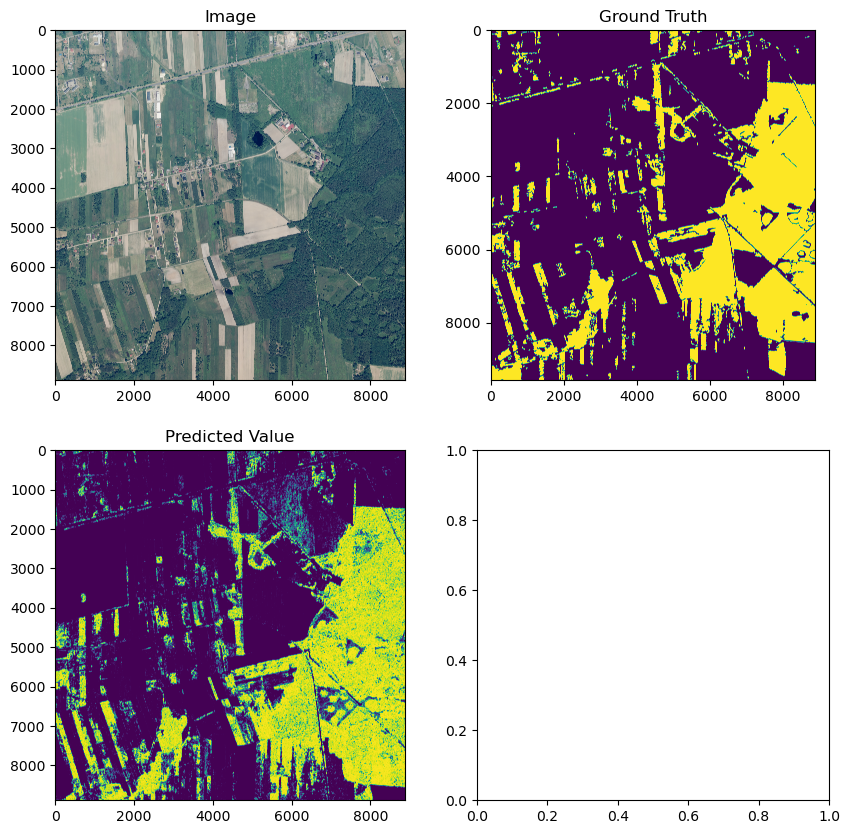

In [17]:
import keras
import tensorflow as tf
name= 'D_5_unet_min'
model = keras.models.load_model(f'models/{name}.h5', compile=False)e
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=metric_calls)
with tf.device('/cpu:0'):
    large_img_predicted = model.predict(np.array([large_img]), callbacks=tensorboard_callback)[0]

fig, ax = plt.subplots(2, 2, figsize=(10,10))
ax[0,0].imshow(large_img)
ax[0,0].set_title('Image')
ax[0,1].imshow(large_mask, vmin=0, vmax=1)
ax[0,1].set_title('Ground Truth')
ax[1,0].imshow(large_img_predicted)
ax[1,0].set_title('Predicted Value')
ax[1,1].imshow(np.abs(large_img_predicted-large_mask[:dim,:dim]))
ax[1,1].set_title('Error Importance')


plt.show()

The error importance is not plot due OOM problems, but nonetheless we can clearly see that all the errors that the logistic regression was making it are fixed, giving a prediction much closer to the ground truth. 